# Projet : Analyse et prédiction des churns dans un service d'abonnement Internet.

Dans un premier temps nous allons importer nos données

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

dataset = load_dataset("d0r1h/customer_churn")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Traitement des données


Affichons nos données et stockons les dans un dataframe Spark

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['age', 'gender', 'security_no', 'region_category', 'membership_category', 'joining_date', 'joined_through_referral', 'referral_id', 'preferred_offer_types', 'medium_of_operation', 'internet_option', 'last_visit_time', 'days_since_last_login', 'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days', 'points_in_wallet', 'used_special_discount', 'offer_application_preference', 'past_complaint', 'complaint_status', 'feedback', 'churn_risk_score'],
        num_rows: 36992
    })
})


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['age', 'gender', 'security_no', 'region_category', 'membership_category', 'joining_date', 'joined_through_referral', 'referral_id', 'preferred_offer_types', 'medium_of_operation', 'internet_option', 'last_visit_time', 'days_since_last_login', 'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days', 'points_in_wallet', 'used_special_discount', 'offer_application_preference', 'past_complaint', 'complaint_status', 'feedback', 'churn_risk_score'],
        num_rows: 36992
    })
})

In [ ]:
type(dataset)

datasets.dataset_dict.DatasetDict

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("taxi-ex1") \
    .config("spark.jars.packages", "com.crealytics:spark-excel_2.11:0.12.2") \
    .config("spark.driver.memory", "6g") \
    .getOrCreate()

df_spark = spark.createDataFrame(dataset['train'])
df_spark.show()

+---+------------------------+--------------+---------------------+----------------+--------------------+---------------------+--------------------+------+---------------+-----------------------+------------+---------------+-------------------+-------------------+----------------------------+--------------+----------------+---------------------+-----------+---------------+-----------+---------------------+
|age|avg_frequency_login_days|avg_time_spent|avg_transaction_value|churn_risk_score|    complaint_status|days_since_last_login|            feedback|gender|internet_option|joined_through_referral|joining_date|last_visit_time|medium_of_operation|membership_category|offer_application_preference|past_complaint|points_in_wallet|preferred_offer_types|referral_id|region_category|security_no|used_special_discount|
+---+------------------------+--------------+---------------------+----------------+--------------------+---------------------+--------------------+------+---------------+---------

On a donc un premier aperçu de nos données possèdant 36992 lignes.

On va maintenant chercher à savoir combien de valeurs None possèdons-nous.

In [ ]:
from pyspark.sql.functions import col, sum

null_counts = df_spark.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_spark.columns])
# convertion de null_counts en dictionnaire
null_counts_dict = null_counts.collect()[0].asDict()
# affichage des colonnes avec des nb de valeurs nulles > 0
columns_with_nulls = {k: v for k, v in null_counts_dict.items() if v > 0}

for column, count in columns_with_nulls.items():
    print(f"Column '{column}' has {count} null values.")

Column 'points_in_wallet' has 3443 null values.
Column 'preferred_offer_types' has 288 null values.
Column 'region_category' has 5428 null values.


Dans le but de connaitre nos données, nous affichons toutes les valeurs que possède chaque feature

In [ ]:
#affichier les valeurs uniques de chaque colonne
for column in df_spark.columns:
    unique_values = df_spark.select(column).distinct().show()

+---+
|age|
+---+
| 29|
| 26|
| 19|
| 54|
| 22|
| 34|
| 50|
| 57|
| 32|
| 43|
| 31|
| 39|
| 25|
| 58|
| 27|
| 63|
| 51|
| 56|
| 52|
| 17|
+---+
only showing top 20 rows

+------------------------+
|avg_frequency_login_days|
+------------------------+
|            -4.403913767|
|            -9.154338862|
|            -16.54721087|
|            -20.12755411|
|            -9.638801336|
|                       7|
|             33.46020535|
|             46.06644526|
|            -9.618914459|
|            -12.70666601|
|             -10.2117474|
|             44.67577891|
|              28.1915704|
|            -20.76148832|
|             55.12785548|
|            -7.044123324|
|             46.38772405|
|             39.63339862|
|             39.14831789|
|            -11.51593981|
+------------------------+
only showing top 20 rows

+--------------+
|avg_time_spent|
+--------------+
|  -705.3118262|
|   1189.848916|
|   -814.380249|
|  -1088.197461|
|   1362.009408|
|  -945.8935506|
|  

On affiche également notre schéma toujours dans l'objectif de connaitre nos données.

In [ ]:
df_spark.printSchema()

root
 |-- age: long (nullable = true)
 |-- avg_frequency_login_days: string (nullable = true)
 |-- avg_time_spent: double (nullable = true)
 |-- avg_transaction_value: double (nullable = true)
 |-- churn_risk_score: long (nullable = true)
 |-- complaint_status: string (nullable = true)
 |-- days_since_last_login: long (nullable = true)
 |-- feedback: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- internet_option: string (nullable = true)
 |-- joined_through_referral: string (nullable = true)
 |-- joining_date: string (nullable = true)
 |-- last_visit_time: string (nullable = true)
 |-- medium_of_operation: string (nullable = true)
 |-- membership_category: string (nullable = true)
 |-- offer_application_preference: string (nullable = true)
 |-- past_complaint: string (nullable = true)
 |-- points_in_wallet: double (nullable = true)
 |-- preferred_offer_types: string (nullable = true)
 |-- referral_id: string (nullable = true)
 |-- region_category: string (nullable 

On va donc commencer notre nétoyage de données.

Dans un premier temps nous allons enlever les valeurs incohérentes dans les colonnes. Certaines de nos features possèdent des valeurs "None" et "Error", nous les rendons alors None.

In [ ]:
from pyspark.sql.functions import when, col, StringType

missing_values = ["None", "Error"]
# dans toutes les colonnes, on remplace les missing_values par la valeur null
df_spark_new = df_spark.replace(missing_values, [None for _ in missing_values])

On obtient alors plus de valeurs None dans notre DataFrame, nous les affichons de nouveau.

In [ ]:
null_counts_new = df_spark_new.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_spark_new.columns])
null_counts_new_dict = null_counts_new.collect()[0].asDict()
columns_with_nulls_new = {k: v for k, v in null_counts_new_dict.items() if v > 0}

for column, count in columns_with_nulls_new.items():
    print(f"Column '{column}' has {count} null values.")

Column 'avg_frequency_login_days' has 3522 null values.
Column 'points_in_wallet' has 3443 null values.
Column 'preferred_offer_types' has 288 null values.
Column 'region_category' has 5428 null values.


Nous avons également constaté des valeurs abérantes dans nos données chiffrés: certaines valeurs sont négatives, cela n'est pas cohérent pour des nombres de jours par exemple. De plus il n'est pas possible de faire une moyenne de plus de 31 jours dans un mois.

In [ ]:
# Filtrer les lignes avec des valeurs négatives dans les colonnes spécifiées
df_spark_new = df_spark_new.filter(
    (col("days_since_last_login") >= 0) &
    (col("points_in_wallet") >= 0) &
    (col("avg_frequency_login_days") >= 0.01) &
    (col("avg_frequency_login_days") <= 31.01) &
    (col("avg_time_spent") >= 0)
)

Dans un but de confidencialité et de performance de notre modèle, nous supprimons ces 2 colonnes qui sont des données privées des utilisateurs et qui de plus ont aucune influence sur la prédiction du risque de désabonnemnt.

In [ ]:
#Supprimer colonnes inutiles
df_spark_clean = df_spark_new.drop("security_no", "referral_id")

On va donc maintenant gérer nos valeurs None. Pour les String nous allons définir les valeurs abérantes et None en 'Unknown'

In [ ]:
# Met en 'Not spcified' donnees None
from pyspark.sql.functions import when

# Remplacer les valeurs '?' par 'Unknown' dans les colonnes 'joined_through_referral' et 'medium_of_operation'
df_spark_clean = df_spark_clean.withColumn("joined_through_referral", when(col("joined_through_referral") == "?", "Unknown").otherwise(col("joined_through_referral")))
df_spark_clean = df_spark_clean.withColumn("medium_of_operation", when(col("medium_of_operation") == "?", "Unknown").otherwise(col("medium_of_operation")))

# met les valeurs None en "Unknown"
df_spark_clean = df_spark_clean.withColumn("medium_of_operation", when(col("medium_of_operation").isNull(), "Unknown").otherwise(col("medium_of_operation")))
df_spark_clean = df_spark_clean.withColumn("region_category", when(col("region_category").isNull(), "Unknown").otherwise(col("region_category")))
df_spark_clean = df_spark_clean.withColumn("preferred_offer_types", when(col("preferred_offer_types").isNull(), "Unknown").otherwise(col("preferred_offer_types")))

On va donc vérifier maintenant si nous possèdons encore des valeurs None. Résultat = Non -> Super !

In [ ]:
null_counts_clean = df_spark_clean.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_spark_clean.columns])
null_counts_dict_clean = null_counts_clean.collect()[0].asDict()
columns_with_nulls_clean = {k: v for k, v in null_counts_dict_clean.items() if v > 0}

for column, count in columns_with_nulls_clean.items():
    print(f"Column '{column}' has {count} null values.")

Nous constatons que notre colonne joining_date sera difficile à analyser. Nous avons donc eu 2 idées que nous avons implémentés :
- Colonne du mois du début d'abonnement : dans le but de détecter des achats compulsif du à des soldes ou des fêtes notamment Noël
- Nombre de mois depuis le début d'abonnement

In [ ]:
# Creation de 2 colonnes à la place de joining_date
from pyspark.sql.functions import substring
from pyspark.sql.functions import datediff, months_between, to_date, lit, abs
from pyspark.sql.functions import month
from pyspark.sql.types import IntegerType

# Nous avons choisie une date fixe à notre entrainement pour éviter que celle-ci change les performances à chaque run
date_const = lit("2024-06-01")
# On convertie notre colonne en date
df_spark_clean = df_spark_clean.withColumn("joining_date", to_date("joining_date", "dd-MM-yyyy"))

# On crée notre colonne donnant le mois de l'abonnement
df_spark_clean = df_spark_clean.withColumn("month_joining_date", month(col("joining_date")).cast(IntegerType()))

# On calcule depuis quand l'utilisateur est abonné
df_spark_clean = df_spark_clean.withColumn("joining_date", abs(months_between("joining_date", date_const)))


Autre changement que nous avons apporté : changer le temps passé lors de la dernière visite en nombre de minutes passées dans le but de facilité les comparaisons

In [ ]:
from pyspark.sql.functions import split, col, expr

# On divise les valeurs de la colonne last_visit_time en heures, minutes et secondes
time_components = split(col("last_visit_time"), ":")
hours = time_components.getItem(0).cast("int")
minutes = time_components.getItem(1).cast("int")
seconds = time_components.getItem(2).cast("int")

# Calcule le nombre de minutes
total_minutes = hours * 60 + minutes + seconds / 60

# On affecte à notre colonne
df_spark_clean = df_spark_clean.withColumn("last_visit_time", total_minutes)


Voici ainsi notre DataFrame Propore et au complet

In [ ]:
df_spark_clean.show()

+---+------------------------+--------------+---------------------+----------------+--------------------+---------------------+--------------------+------+---------------+-----------------------+------------+------------------+-------------------+-------------------+----------------------------+--------------+----------------+---------------------+---------------+---------------------+------------------+
|age|avg_frequency_login_days|avg_time_spent|avg_transaction_value|churn_risk_score|    complaint_status|days_since_last_login|            feedback|gender|internet_option|joined_through_referral|joining_date|   last_visit_time|medium_of_operation|membership_category|offer_application_preference|past_complaint|points_in_wallet|preferred_offer_types|region_category|used_special_discount|month_joining_date|
+---+------------------------+--------------+---------------------+----------------+--------------------+---------------------+--------------------+------+---------------+-------------

Dans l'objectif de mettre en place une matrice de corrélation, nous allons crée un second dataframe uniquement remplit de données numériques. Pour cela nous avons stocké nos données String dans une bibliothèque à l'aide d'int

In [ ]:
# Mise en Int de tout les valeurs du tableau
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

df_int = df_spark_clean.alias("df_spark_copy")

# Colonnes en String
columns_to_map = ["complaint_status", "feedback", "internet_option", "medium_of_operation", "membership_category", "preferred_offer_types", "region_category", "joined_through_referral", "gender"]

# Création des dictionnaires
mappings = {}

#On ajoute aux dictionnaires
for col_name in columns_to_map:
    unique_values = df_int.select(col_name).distinct().rdd.flatMap(lambda x: x).collect()
    mapping_dict = {val: idx for idx, val in enumerate(unique_values)}
    mappings[col_name] = mapping_dict

print(mappings) # Affichage

# Fonction pour créer un UDF à partir d'un dictionnaire de mapping
def create_map_udf(mapping_dict):
    return udf(lambda x: mapping_dict.get(x, -1), IntegerType())

# Appliquer les mappings aux colonnes
for col_name, mapping_dict in mappings.items():
    map_udf = create_map_udf(mapping_dict)
    df_int = df_int.withColumn(col_name, map_udf(col(col_name)))

# Transforme Yes=1 No=0
df_int = df_int.withColumn("offer_application_preference", when(col("offer_application_preference") == "Yes", 1).when(col("offer_application_preference") == "No", 0))
df_int = df_int.withColumn("past_complaint", when(col("past_complaint") == "Yes", 1).when(col("past_complaint") == "No", 0))
df_int = df_int.withColumn("used_special_discount", when(col("used_special_discount") == "Yes", 1).when(col("used_special_discount") == "No", 0))

# Afficher les résultats
df_int.show()

{'complaint_status': {'No Information Available': 0, 'Unsolved': 1, 'Solved': 2, 'Solved in Follow-up': 3, 'Not Applicable': 4}, 'feedback': {'Poor Product Quality': 0, 'Poor Website': 1, 'Quality Customer Care': 2, 'No reason specified': 3, 'Products always in Stock': 4, 'Too many ads': 5, 'Poor Customer Service': 6, 'Reasonable Price': 7, 'User Friendly Website': 8}, 'internet_option': {'Wi-Fi': 0, 'Fiber_Optic': 1, 'Mobile_Data': 2}, 'medium_of_operation': {'Unknown': 0, 'Both': 1, 'Desktop': 2, 'Smartphone': 3}, 'membership_category': {'Premium Membership': 0, 'Gold Membership': 1, 'Basic Membership': 2, 'Silver Membership': 3, 'Platinum Membership': 4, 'No Membership': 5}, 'preferred_offer_types': {'Credit/Debit Card Offers': 0, 'Without Offers': 1, 'Unknown': 2, 'Gift Vouchers/Coupons': 3}, 'region_category': {'Unknown': 0, 'Village': 1, 'Town': 2, 'City': 3}, 'joined_through_referral': {'Unknown': 0, 'No': 1, 'Yes': 2}, 'gender': {'F': 0, 'M': 1, 'Unknown': 2}}
+---+------------

On affiche maintenant le nombre de données que présente à présent notre DataFrame

In [ ]:
print(df_int.count())

26121


# Analyse des données

Dans cette partie nous allons faire des visualisations graphiques dans le but de connaitre mieux l'influence de nos features sur la prédiction du risque de désabonnement

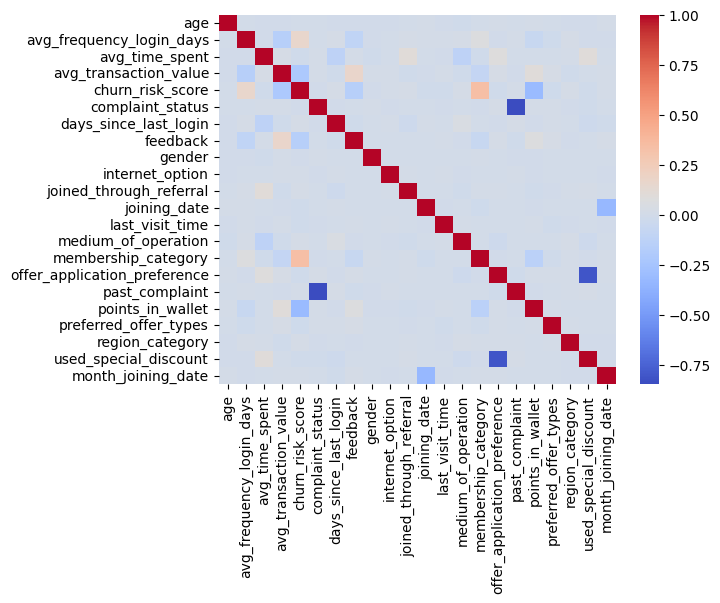

In [ ]:
# Matrice Correlation
df_pandas = df_int.toPandas()
corr_matrix = df_pandas.corr()
import seaborn as sns
import matplotlib.pyplot as plt

# créer un heatmap à l'aide de seaborn
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")

# afficher le heatmap
plt.show()

On constate que les Churns ont une coorélation plus importantes avec 5 variables : la frequence de jours de connexion, la moyenne du nombre de transactions, les feedbacks, leurs catégories d'adhésion et le nombre de points de fidelité.

Dans le but de pouvoir avoir un comparaison sur l'influence ou non d'une feature sur notre préduction, nous allons afficher la proportion de churn dans notre Dataset

In [ ]:
from pyspark.sql.functions import avg, sum
import pandas as pd
import altair as alt

# Nombre de churn pour chaque
df_churn = df_spark_clean.groupBy("churn_risk_score").count()

# Somme total
total_count = df_churn.select(sum("count")).collect()[0][0]

# Proportion de chaque valeur de churn
df_churn = df_churn.withColumn("proportion", (col("count") / total_count)*100)

# Convertir le DataFrame PySpark en DataFrame pandas
data_pd = df_churn.toPandas()

# couleurs personnalisées
color_scale = alt.Scale(
    domain=[0, 1],
    range=['green', 'red']
)

#graphique Nightingale Rose Chart avec Altair
base = alt.Chart(data_pd).encode(
    theta=alt.Theta("proportion:Q", stack=True),
    radius=alt.Radius("proportion:Q", scale=alt.Scale(type="sqrt", zero=True, rangeMin=150)),
    tooltip=['proportion:Q','count:Q', 'churn_risk_score:Q'],
    color=alt.Color("churn_risk_score:N", scale=color_scale)
).properties(
    width=400,  # Taille du graphique
    height=400,
    title="Nightingale Rose Chart de la proportion du risque de désabonnement"  # Titre du graphique
)

# Ajouter les arcs et les étiquettes
c1 = base.mark_arc(innerRadius=100, outerRadius=200, stroke="#fff")
c2 = base.mark_text(radiusOffset=20).encode(text=alt.Text("churn_risk_score:Q", format=".1f"))

# Afficher le graphique
chart = c1 + c2
chart.display()


alt.LayerChart(...)

Dans un second temps nous allons regardé si l'age d'une personne à une influence sur le désabonnement et nous affichons la couleur avec la proportion de personnes.

In [ ]:
# Churn en fct de l'age
from pyspark.sql.functions import avg, col, count
df_churn_age = df_spark_clean.groupBy("age").agg((avg("churn_risk_score") * 100).alias("avg_churn_percentage"), count("churn_risk_score").alias("Nombre_Clients"))
df_churn_age = df_churn_age.orderBy('age')

# Importation le package Altair
import altair as alt
import pandas as pd

# Convertir le DataFrame PySpark en DataFrame pandas
data_pd = df_churn_age.toPandas()

# Histogramme
alt.Chart(data_pd).mark_bar().encode(
    x=alt.X('age:Q', axis=alt.Axis(title="Age des clients (en ans)")),
    y=alt.Y('avg_churn_percentage:Q', axis=alt.Axis(title="Pourcentage de client avec un risque de désabonnement")),
    tooltip=['age:Q', 'avg_churn_percentage:Q', 'Nombre_Clients:Q'], # Afin de pouvoir avoir les informations de chaque point lorsque l'on passe notre souris
    color = 'Nombre_Clients:Q'
).properties(
    width=800, # Taille du graphique
    height=400,
    title="Histogramme du risque de désabonnement selon l'age", # Titre du graphique
).interactive() # Pouvoir zoomer sur le graphique

alt.Chart(...)

Nous constatons que l'age n'a pas réellement de grosse influance.

On va donc comparer cette fois-ci avec le genre des utilisateurs

In [ ]:
from pyspark.sql.functions import count

# pour chaque genre
df_churn = df_spark_clean.groupBy("gender").agg((avg("churn_risk_score") * 100).alias("avg_churn_percentage"))
df_churn2 = df_spark_clean.groupBy("gender").count()

data_pd = df_churn.toPandas()
data_pd2 = df_churn2.toPandas()

# couleurs personnalisées
color_scale = alt.Scale(
    domain=['M', 'F', 'Unknown'],
    range=['blue', 'red', 'green']
)

# Créer un graphique Nightingale Rose Chart avec Altair sur moyenne prédiction churn
base = alt.Chart(data_pd).encode(
    theta=alt.Theta("avg_churn_percentage:Q", stack=True),
    radius=alt.Radius("avg_churn_percentage:Q", scale=alt.Scale(type="sqrt", zero=True, rangeMin=150)),
    tooltip=['gender:N', 'avg_churn_percentage:Q'],
    color=alt.Color("gender:N", scale=color_scale)
).properties(
    width=400,  # Taille du graphique
    height=400,
    title="Nightingale Rose Chart du risque de désabonnement selon le genre"  # Titre du graphique
)

# Histogramme du nombre de clients selon leur genre
base2 = alt.Chart(data_pd2).mark_bar().encode(
    x=alt.X('gender:N', axis=alt.Axis(title="Genre des clients")),
    y=alt.Y('count:Q', axis=alt.Axis(title="Nombre de clients")),
    tooltip=['gender:N', 'count:Q'],  # Afin de pouvoir avoir les informations de chaque point lorsque l'on passe notre souris
    color=alt.Color("gender:N", scale=color_scale)
).properties(
    width=400,  # Taille du graphique
    height=400,
    title="Histogramme du nombre de clients selon leur genre"  # Titre du graphique
).interactive()  # Pouvoir zoomer sur le graphique

# Ajouter les arcs et les étiquettes
c1 = base.mark_arc(innerRadius=100, outerRadius=200, stroke="#fff")
c2 = base.mark_text(radiusOffset=20).encode(text=alt.Text("avg_churn_percentage:Q", format=".1f"))

# Afficher le graphique
chart = (c1 + c2) | base2
chart.display()


alt.HConcatChart(...)

De même on constate que le genre n'a pas de réelle influence sur le désabonnement des clients

Regardons maintenant si les utilisateurs ayant eu des achats compulsifs ont tendance à ce désabonner

In [ ]:
# Churn en fct du mois d'abonnement
from pyspark.sql.functions import when
df_churn = df_spark_clean.groupBy("month_joining_date").agg((avg("churn_risk_score") * 100).alias("avg_churn_percentage"), count("churn_risk_score").alias("Nombre_Clients"))
df_churn = df_churn.withColumn("Month",
                               when(col("month_joining_date") == "01", "Janvier")
                               .when(col("month_joining_date") == "02", "Fevrier")
                               .when(col("month_joining_date") == "03", "Mars")
                               .when(col("month_joining_date") == "04", "Avril")
                               .when(col("month_joining_date") == "05", "Mai")
                               .when(col("month_joining_date") == "06", "Juin")
                               .when(col("month_joining_date") == "07", "Juillet")
                               .when(col("month_joining_date") == "08", "Août")
                               .when(col("month_joining_date") == "09", "Septembre")
                               .when(col("month_joining_date") == "10", "Octobre")
                               .when(col("month_joining_date") == "11", "Novembre")
                               .otherwise("Décembre"))
df_churn = df_churn.orderBy('month_joining_date')

data_pd = df_churn.toPandas()

# Définir l'ordre des mois
month_order = ["Janvier", "Fevrier", "Mars", "Avril", "Mai", "Juin", "Juillet", "Août", "Septembre", "Octobre", "Novembre", "Décembre"]

# Histogramme
alt.Chart(data_pd).mark_bar().encode(
    x=alt.X('Month:N', sort=month_order, axis=alt.Axis(title="Mois d'abonnement des clients")),
    y=alt.Y('avg_churn_percentage:Q', axis=alt.Axis(title="Pourcentage de client avec un risque de désabonnement")),
    tooltip=['Month:N', 'avg_churn_percentage:Q', 'Nombre_Clients:Q'], # Afin de pouvoir avoir les informations de chaque point lorsque l'on passe notre souris
    color='Nombre_Clients:Q'
).properties(
    width=800, # Taille du graphique
    height=400,
    title="Histogramme du risque de désabonnement selon le mois d'abonnement", # Titre du graphique
).interactive() # Pouvoir zoomer sur le graphique

alt.Chart(...)

Les achats compulsifs ne nous montre pas un grand impact sur le risque de désabonnement.

Peut-être que la localisation du client à plus d'influence?

In [ ]:
# Churn en fct de la localisation
df_churn = df_spark_clean.groupBy("region_category").agg((avg("churn_risk_score") * 100).alias("avg_churn_percentage"), count("churn_risk_score").alias("Nombre_Clients"))
data_pd = df_churn.toPandas()

# Histogramme
alt.Chart(data_pd).mark_bar().encode(
    x=alt.X('region_category:N', axis=alt.Axis(title="Localisation des clients")),
    y=alt.Y('avg_churn_percentage:Q', axis=alt.Axis(title="Pourcentage de client avec un risque de désabonnement")),
    tooltip=['region_category:N', 'avg_churn_percentage:Q', 'Nombre_Clients:Q'], # Afin de pouvoir avoir les informations de chaque point lorsque l'on passe notre souris
    color='Nombre_Clients:Q'
).properties(
    width=800, # Taille du graphique
    height=400,
    title="Histogramme du risque de désabonnement selon la localisation des clients", # Titre du graphique
).interactive() # Pouvoir zoomer sur le graphique

alt.Chart(...)

De même cette feature à peu d'influence.

On va maintenant s'intéresser au variable avec plus de corrélation

Commençons par la fréquence de jours de connexion de clients

In [ ]:
from pyspark.sql.functions import round

# Arrondir les valeurs de avg_frequency_login_days et les grouper
df_churn = df_spark_clean.withColumn("avg_frequency_login_days_rounded", round(col("avg_frequency_login_days")))
df_churn = df_churn.groupBy("avg_frequency_login_days_rounded").agg((avg("churn_risk_score") * 100).alias("avg_churn_percentage"), count("churn_risk_score").alias("Nombre_Clients"))
df_churn = df_churn.orderBy('avg_frequency_login_days_rounded')

data_pd = df_churn.toPandas()

# Histogramme
alt.Chart(data_pd).mark_bar().encode(
    x=alt.X('avg_frequency_login_days_rounded:Q', axis=alt.Axis(title="Moyenne du nombre de jours de connexion")),
    y=alt.Y('avg_churn_percentage:Q', axis=alt.Axis(title="Pourcentage de clients avec un risque de désabonnement")),
    tooltip=['avg_frequency_login_days_rounded:Q', 'avg_churn_percentage:Q', 'Nombre_Clients:Q'], # Afficher les informations de chaque point au survol
    color='Nombre_Clients:Q'
).properties(
    width=800, # Taille du graphique
    height=400,
    title="Histogramme du risque de désabonnement selon la fréquence moyenne de connexion", # Titre du graphique
).interactive() # Pouvoir zoomer sur le graphique


alt.Chart(...)

On constate que les clients passant le plus de temps de connexion ont tendance à vouloir résilier leur abonnement probablement pour changer d'opérateur avec un offre plus aléchante dans ce cas.

Regardons cette fois-ci les feedbacks

In [ ]:
df_churn = df_spark_clean.groupBy("feedback").agg((avg("churn_risk_score") * 100).alias("avg_churn_percentage"), count("churn_risk_score").alias("Nombre_Clients"))
df_churn.show()
data_pd = df_churn.toPandas()

# Histogramme
alt.Chart(data_pd).mark_bar().encode(
    x=alt.X('feedback:N', axis=alt.Axis(title="Feedbacks des clients")),
    y=alt.Y('avg_churn_percentage:Q', axis=alt.Axis(title="Pourcentage de client avec un risque de désabonnement")),
    tooltip=['feedback:N', 'avg_churn_percentage:Q', 'Nombre_Clients:Q'], # Afin de pouvoir avoir les informations de chaque point lorsque l'on passe notre souris
    color='feedback:N'
).properties(
    width=800, # Taille du graphique
    height=400,
    title="Histogramme du risque de désabonnement selon les feedbacks des clients", # Titre du graphique
).interactive() # Pouvoir zoomer sur le graphique

+--------------------+--------------------+--------------+
|            feedback|avg_churn_percentage|Nombre_Clients|
+--------------------+--------------------+--------------+
|Poor Product Quality|   64.77750719504095|          4517|
|        Poor Website|   62.81010374379793|          4434|
|Quality Customer ...|                 0.0|           965|
| No reason specified|   63.00182481751825|          4384|
|Products always i...|                 0.0|           976|
|        Too many ads|   62.35267452402539|          4412|
|Poor Customer Ser...|  63.958474385014675|          4431|
|    Reasonable Price|                 0.0|           998|
|User Friendly Web...|                 0.0|          1004|
+--------------------+--------------------+--------------+



alt.Chart(...)

On constate que les feedbacks positives ne sont jamais prédit comment potentielle désabonnement, d'où la corrélation importante avec notre valeur à prédire

Comparons cette fois avec le status d'adhésion

In [ ]:
df_churn = df_spark_clean.groupBy("membership_category").agg((avg("churn_risk_score") * 100).alias("avg_churn_percentage"), count("churn_risk_score").alias("Nombre_Clients"))
df_churn.show()
data_pd = df_churn.toPandas()

# Définir l'ordre des mois
ordre = ["No Membership", "Basic Membership", "Silver Membership", "Gold Membership", "Premium Membership", "Platinum Membership"]

# Histogramme
alt.Chart(data_pd).mark_bar().encode(
    x=alt.X('membership_category:N', sort=ordre, axis=alt.Axis(title="Catégorie d'adhésion des clients")),
    y=alt.Y('avg_churn_percentage:Q', axis=alt.Axis(title="Pourcentage de client avec un risque de désabonnement")),
    tooltip=['membership_category:N', 'avg_churn_percentage:Q', 'Nombre_Clients:Q'], # Afin de pouvoir avoir les informations de chaque point lorsque l'on passe notre souris
    color='membership_category:N'
).properties(
    width=800, # Taille du graphique
    height=400,
    title="Histogramme du risque de désabonnement selon les catégories d'adhésion des clients", # Titre du graphique
).interactive() # Pouvoir zoomer sur le graphique

+-------------------+--------------------+--------------+
|membership_category|avg_churn_percentage|Nombre_Clients|
+-------------------+--------------------+--------------+
| Premium Membership|                 0.0|          3173|
|    Gold Membership|  37.247973394304715|          4811|
|   Basic Membership|   96.80712827176536|          5387|
|  Silver Membership|   42.29777256740914|          4265|
|Platinum Membership|                 0.0|          3066|
|      No Membership|   96.82598265362613|          5419|
+-------------------+--------------------+--------------+



alt.Chart(...)

On constate que plus l'adhésion des clients est importante plus ils ont tendances à rester abonné.

In [ ]:
df_churn = df_spark_clean.withColumn("points_in_wallet_rounded", round(col("points_in_wallet")/25)*25)
df_churn = df_churn.groupBy("points_in_wallet_rounded").agg((avg("churn_risk_score") * 100).alias("avg_churn_percentage"), count("churn_risk_score").alias("Nombre_Clients"))
df_churn = df_churn.orderBy('points_in_wallet_rounded')

data_pd = df_churn.toPandas()

# Histogramme
alt.Chart(data_pd).mark_bar().encode(
    x=alt.X('points_in_wallet_rounded:Q', axis=alt.Axis(title="Points dans son portefeuille")),
    y=alt.Y('avg_churn_percentage:Q', axis=alt.Axis(title="Pourcentage de clients avec un risque de désabonnement")),
    tooltip=['points_in_wallet_rounded:Q', 'avg_churn_percentage:Q', 'Nombre_Clients:Q'], # Afficher les informations de chaque point au survol
    color='Nombre_Clients:Q'
).properties(
    width=800, # Taille du graphique
    height=400,
    title="Histogramme du risque de désabonnement selon le nombre de point dans le portefeuille des clients", # Titre du graphique
).interactive() # Pouvoir zoomer sur le graphique


alt.Chart(...)

On constate que nos valeurs sont fortement concentré entre 500 et 820. On remarque alors qu'au début nos clients ont un très grande tendance à se désabonner et pas la suite à rester fidèle.

# Description de problème sous forme ML

Après avoir analyser nos données, on peut maintenant construire notre modèle de prédiction

Dans un premier temps nous allons importer les bibliothèques nécessaires

In [ ]:
from pyspark.sql.functions import col, when
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import (LogisticRegression, RandomForestClassifier,
                                       GBTClassifier, DecisionTreeClassifier,
                                       NaiveBayes, LinearSVC)
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

Nous allons préparer et transformer nos données pour le Modèle

In [ ]:
# Converti les valeurs de la colonne en type double
df_spark_clean = df_spark_clean.withColumn("avg_frequency_login_days",col("avg_frequency_login_days").cast(DoubleType()))

# Indexation et Encodage des Colonnes de Type String
string_cols = [col_name for col_name, dtype in df_spark_clean.dtypes if dtype == "string"]
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="skip") for col in string_cols]
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=indexer.getOutputCol() + "_ohe") for indexer in indexers]
pipeline_encoder = Pipeline(stages=indexers + encoders)
df_spark_encoded = pipeline_encoder.fit(df_spark_clean).transform(df_spark_clean)

# selection des colonnes
feature_columns = [col + "_index_ohe" for col in string_cols if col + "_index_ohe" in df_spark_encoded.columns] + [
    "age",
    "avg_frequency_login_days",
    "avg_time_spent",
    "avg_transaction_value",
    "days_since_last_login",
    "points_in_wallet",
    "month_joining_date"
]

# Assembler les colonnes de caractéristiques en un vecteur
assembler = VectorAssembler(inputCols=feature_columns, outputCol="ass_features")
df_spark_assembled = assembler.transform(df_spark_encoded)
# Normaliser les caractéristiques
scaler = StandardScaler(inputCol="ass_features", outputCol="scaled_features")
df_spark_scaled = scaler.fit(df_spark_assembled).transform(df_spark_assembled)


On peut maintenant séparer notre jeu de données en 3 : TrainingSet, ValidationSet et TestSet

In [ ]:
# entraînement, de validation et de test (75%, 15%, 10%)
train_data, val_data, test_data = df_spark_scaled.randomSplit([0.75, 0.15, 0.10], seed=42)

# Sélectionner les colonnes de labels et de caractéristiques pour l'entraînement
train_data_final = train_data.select(col("scaled_features"), col("churn_risk_score").alias("label"))
val_data_final = val_data.select(col("scaled_features"), col("churn_risk_score").alias("label"))

On definit ici les différents modèles que nous allons essayer et on fait varier leurs hyperparamètres à l'aide des Grilles

In [ ]:
models = {
    "LogisticRegression": LogisticRegression(featuresCol='scaled_features', labelCol='label'),
    "RandomForest": RandomForestClassifier(featuresCol='scaled_features', labelCol='label'),
    "GradientBoostedTrees": GBTClassifier(featuresCol='scaled_features', labelCol='label'),
    "DecisionTree": DecisionTreeClassifier(featuresCol='scaled_features', labelCol='label'),
    "NaiveBayes": NaiveBayes(featuresCol='scaled_features', labelCol='label'),
    "LinearSVC": LinearSVC(featuresCol='scaled_features', labelCol='label')
}

# grilles de paramètres pour chaque modèle
param_grids = {
    "LogisticRegression": ParamGridBuilder().addGrid(models["LogisticRegression"].regParam, [0.1, 0.01]).addGrid(models["LogisticRegression"].elasticNetParam, [0.0, 0.5, 1.0]).build(),
    "RandomForest": ParamGridBuilder().addGrid(models["RandomForest"].numTrees, [10, 20, 30]).addGrid(models["RandomForest"].maxDepth, [5, 10, 15]).build(),
    "GradientBoostedTrees": ParamGridBuilder().addGrid(models["GradientBoostedTrees"].maxIter, [10, 20, 30]).addGrid(models["GradientBoostedTrees"].maxDepth, [5, 10, 15]).build(),
    "DecisionTree": ParamGridBuilder().addGrid(models["DecisionTree"].maxDepth, [5, 10, 15]).addGrid(models["DecisionTree"].maxBins, [32, 64]).build(),
    "NaiveBayes": ParamGridBuilder().addGrid(models["NaiveBayes"].smoothing, [0.0, 1.0, 10.0]).build(),
    "LinearSVC": ParamGridBuilder().addGrid(models["LinearSVC"].regParam, [0.1, 0.01]).build()
}

On crée des evaluateurs qui permettrons de calculer les métriques de nos modèles

In [ ]:
# Évaluateurs pour les métriques
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label")
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

On va done entrainer et calculer les performances de nos modèles

In [ ]:
results = []

for model_name, model in models.items():
    print(f"Training {model_name}...")
    param_grid = param_grids[model_name]
    crossval = CrossValidator(estimator=model, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

    #TRaining
    cv_model = crossval.fit(train_data_final)
    # prédictions sur l'ensemble de validation
    val_predictions = cv_model.transform(val_data_final)

    # Évaluer
    accuracy = evaluator_accuracy.evaluate(val_predictions)
    precision = evaluator_precision.evaluate(val_predictions)
    recall = evaluator_recall.evaluate(val_predictions)
    f1 = evaluator_f1.evaluate(val_predictions)
    roc_auc = evaluator.evaluate(val_predictions)

    # résultats
    results.append({
        "Model": model_name,
        "BestModel": cv_model.bestModel,
        "Predictions": val_predictions,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc,
        "Moyenne Cross Validation": np.mean(cv_model.avgMetrics),
        "Ecart type": np.std(cv_model.avgMetrics)
    })


Training LogisticRegression...
Training RandomForest...
Training GradientBoostedTrees...
Training DecisionTree...
Training NaiveBayes...
Training LinearSVC...


On compare donc nos résultats

In [ ]:
results_df = pd.DataFrame([{
    "Model": result["Model"],
    "Accuracy": result["Accuracy"],
    "Precision": result["Precision"],
    "Recall": result["Recall"],
    "F1 Score": result["F1 Score"],
    "ROC AUC": result["ROC AUC"],
    "Moyenne Cross Validation": result["Moyenne Cross Validation"],
    "Ecart type": result["Ecart type"]
} for result in results])

print(results_df)

                  Model  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
0    LogisticRegression  0.845081   0.862164  0.845081  0.844851  0.956112   
1          RandomForest  0.935451   0.935887  0.935451  0.935512  0.975889   
2  GradientBoostedTrees  0.939324   0.940108  0.939324  0.939400  0.977154   
3          DecisionTree  0.926414   0.926471  0.926414  0.926337  0.959165   
4            NaiveBayes  0.782856   0.782593  0.782856  0.782288  0.699251   
5             LinearSVC  0.848180   0.875806  0.848180  0.847330  0.948130   

   Moyenne Cross Validation  Ecart type  
0                  0.947996    0.011817  
1                  0.967596    0.005114  
2                  0.968434    0.007340  
3                  0.890574    0.088222  
4                  0.691863    0.006341  
5                  0.939414    0.009945  


On constate que notre meilleur modèle est GBTClassifier.

On va vérifier ça en affichant notre modèle avec le meilleur f1score et on va également afficher ses hyperparamètres.

In [ ]:
import numpy as np

F1_values = [result["F1 Score"] for result in results]
best_F1_index = np.argmax(F1_values)
# modèle avec le plus grand F1 Score
best_F1_model_results = results[best_F1_index]

# récupérer les hyperparamètres
hyperparameters = best_F1_model_results["BestModel"].extractParamMap()
print(f"Hyperparamètres pour le modèle {best_F1_model_results['Model']} avec le plus grand F1 score :\n")
for param_name, param_value in hyperparameters.items():
    print(f"    {param_name.name}: {param_value}")

Hyperparamètres pour le modèle GradientBoostedTrees avec le plus grand F1 score :

    cacheNodeIds: False
    checkpointInterval: 10
    featureSubsetStrategy: all
    featuresCol: scaled_features
    impurity: variance
    labelCol: label
    leafCol: 
    lossType: logistic
    maxBins: 32
    maxDepth: 5
    maxIter: 30
    maxMemoryInMB: 256
    minInfoGain: 0.0
    minInstancesPerNode: 1
    minWeightFractionPerNode: 0.0
    predictionCol: prediction
    probabilityCol: probability
    rawPredictionCol: rawPrediction
    seed: -5727026145477880835
    stepSize: 0.1
    subsamplingRate: 1.0
    validationTol: 0.01


On stock ainsi dans une variable notre meilleur modèle

In [ ]:
model_best = best_F1_model_results["BestModel"]

# Si on devait recréer notre modèle :
model_recree = GBTClassifier(cacheNodeIds=False,
                      checkpointInterval=10,
                      featureSubsetStrategy='all',
                      featuresCol='scaled_features',
                      labelCol='label',
                      lossType='logistic',
                      maxBins=32,
                      maxDepth=5,
                      maxIter=30,
                      maxMemoryInMB=256,
                      minInfoGain=0.0,
                      minInstancesPerNode=1,
                      minWeightFractionPerNode=0.0,
                      predictionCol='prediction',
                      seed=1806664815509264457,
                      stepSize=0.1,
                      subsamplingRate=1.0,
                      validationTol=0.01)

Dans le but d'ameliorer nos performances, nous allons contruire un modèle d'ensemble learninng avec nos 3 meilleurs modèles (selon le F1score) que l'on affiche

In [ ]:
from pyspark.sql.functions import expr, monotonically_increasing_id, col, udf
from pyspark.sql.types import IntegerType, DoubleType
import numpy as np
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

val_data_final = val_data_final.withColumn("index", monotonically_increasing_id())

# meilleurs modèles
f1_scores = [result["F1 Score"] for result in results]
best_model_indices = np.argsort(f1_scores)[-3:]
best_models = [results[i]["BestModel"] for i in best_model_indices]
print([results[i]["Model"] for i in best_model_indices])

# prédictions sur chaque modèle
val_predictions_list = [model.transform(val_data_final).select("index", "prediction").withColumnRenamed("prediction", f"prediction_{i}")
                        for i, model in enumerate(best_models)]

# jointure sur 1 seul dataframe
val_predictions_combined = val_data_final
for i, val_pred in enumerate(val_predictions_list):
    val_predictions_combined = val_predictions_combined.join(val_pred, on="index")

# défini la prédiction à faire en fonction des autres modèles
def majority_vote(*predictions):
    return int(np.argmax(np.bincount([int(pred) for pred in predictions])))

# Enregistrer la fonction de vote majoritaire comme UDF
majority_vote_udf = udf(lambda *predictions: majority_vote(*predictions), IntegerType())
val_predictions_combined = val_predictions_combined.withColumn(
    "ensemble_prediction",
    majority_vote_udf(col("prediction_0"), col("prediction_1"), col("prediction_2"))
)
val_predictions_combined = val_predictions_combined.withColumn(
    "ensemble_prediction", col("ensemble_prediction").cast(DoubleType())
)

# Évaluateurs pour les métriques
evaluator = BinaryClassificationEvaluator(rawPredictionCol="ensemble_prediction", labelCol="label")
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="ensemble_prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="ensemble_prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="ensemble_prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="ensemble_prediction", metricName="f1")

# Calculer les métriques d'évaluation
accuracy = evaluator_accuracy.evaluate(val_predictions_combined)
precision = evaluator_precision.evaluate(val_predictions_combined)
recall = evaluator_recall.evaluate(val_predictions_combined)
f1_score = evaluator_f1.evaluate(val_predictions_combined)
auc_roc = evaluator.evaluate(val_predictions_combined)

print("Ensemble Model Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("AUC-ROC:", auc_roc)


['DecisionTree', 'RandomForest', 'GradientBoostedTrees']
Ensemble Model Metrics:
Accuracy: 0.9375161373612187
Precision: 0.9381054205113633
Recall: 0.9375161373612187
F1 Score: 0.9375852172940284
AUC-ROC: 0.9383952233974642


 # Visualiser et interpreter les résultats

On constate que notre modèle d'ensemble learning possède des performances légèrement moin bien que notre GBTClassifier, qui est notre meilleur modèles puisqu'il possède le meilleur F1SCORE.

On va donc garder ce dernier dans le but de faire des tests pour un futur mise en production.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.sql.functions import col
import numpy as np

test_data_final = test_data.select(col("scaled_features"), col("churn_risk_score").alias("label"))
y_pred = model_best.transform(test_data_final).withColumnRenamed("prediction", "test_prediction")

# Évaluateurs pour les métriques
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="test_prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="test_prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="test_prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="test_prediction", metricName="f1")
evaluator_roc_auc = BinaryClassificationEvaluator(rawPredictionCol="test_prediction", labelCol="label", metricName="areaUnderROC")
# Calculer les métriques d'évaluation
accuracy = evaluator_accuracy.evaluate(y_pred)
precision = evaluator_precision.evaluate(y_pred)
recall = evaluator_recall.evaluate(y_pred)
f1_score = evaluator_f1.evaluate(y_pred)
auc_roc = evaluator_roc_auc.evaluate(y_pred)

print("Ensemble Model Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("AUC-ROC:", auc_roc)

Ensemble Model Metrics:
Accuracy: 0.9383959705540488
Precision: 0.939370239645748
Recall: 0.9383959705540488
F1 Score: 0.9384866146752275
AUC-ROC: 0.9397737484770018


On peut donc afficher nos résultats sous forme d'une matrice de confusion

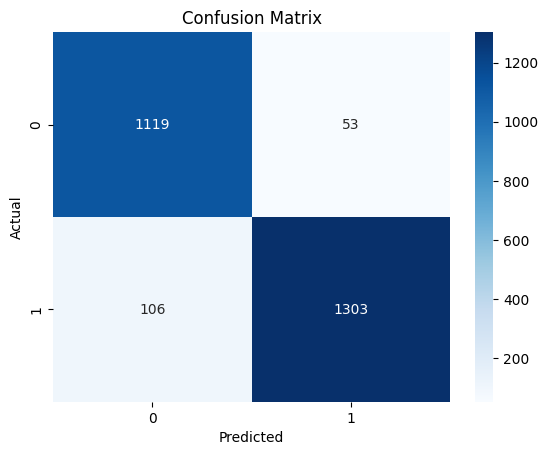

In [ ]:
y_true_list = test_data_final.select("label").rdd.flatMap(lambda x: x).collect()
y_pred_list = y_pred.select("test_prediction").rdd.flatMap(lambda x: x).collect()

conf_matrix = confusion_matrix(y_true_list, y_pred_list)

# Afficher la matrice de confusion
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Cette matrice confirme nos bon résultats

On peut faire un affichage semblable sous forme d'histogramme

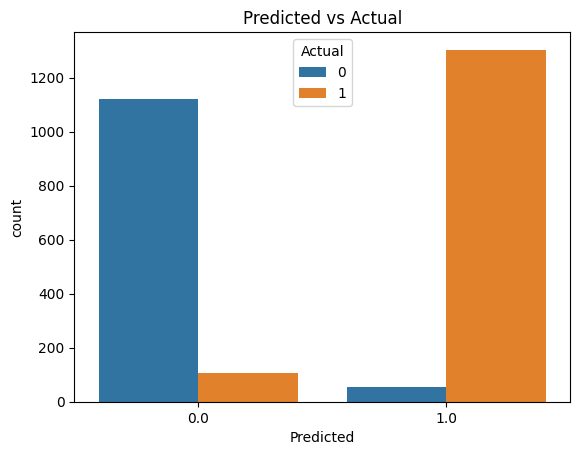

In [ ]:
import seaborn as sns

# Créer un DataFrame pour les données réelles et prédites
df = pd.DataFrame({'Actual': y_true_list, 'Predicted': y_pred_list})

# Plot
sns.countplot(x='Predicted', hue='Actual', data=df)
plt.title('Predicted vs Actual')
plt.show()


On affiche Ici notre courbe ROC, celle ci ne possède pas enormément de point mais met en avant que notre résultat possède de bonne performance

In [ ]:
#ROC croube
import altair as alt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true_list, y_pred_list)

roc_data = pd.DataFrame({'False Positive Rate': fpr, 'True Positive Rate': tpr})

alt.Chart(roc_data).mark_line().encode(
    x='False Positive Rate',
    y='True Positive Rate',
    tooltip=['False Positive Rate', 'True Positive Rate']
).properties(
    title='ROC Curve'
).interactive()



alt.Chart(...)

De même pour notre courbe Precision-Recall qui montre bien que ces 2 valeurs possèdent de très bonnes métriques

In [ ]:
#Courbe de Précision-Rappel
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true_list, y_pred_list)

pr_data = pd.DataFrame({'Precision': precision[:-1], 'Recall': recall[:-1]})

alt.Chart(pr_data).mark_line().encode(
    x='Recall',
    y='Precision',
    tooltip=['Precision', 'Recall']
).properties(
    title='Precision-Recall Curve'
).interactive()


alt.Chart(...)

En conclusion, nous avons bien reussi à constuire un modèle de prédiction du risque de désabonnement chez les utilisateurs de notre service internet avec une très bonne perfomance. Ce qui permettra à notre équipe de marketing de mettre en oeuvre des techniques adaptées pour conserver nos clients.